In [1]:
from polar_codes.polar_code import PolarCode
from polar_codes.channels.bpsk_awgn_channel import BpskAwgnChannel
import numpy as np
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from tqdm import tqdm
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(512, 256)
        self.act1 = nn.Hardswish ()
        self.bn1 = nn.BatchNorm1d(256, momentum=0.9999)

        self.lin2 = nn.Linear(256, 128)
        self.act2 = nn.Hardswish ()
        self.bn2 = nn.BatchNorm1d(128, momentum=0.9999)

        self.lin3 = nn.Linear(128, 64)
        self.act3 = nn.Hardswish()
        self.bn3 = nn.BatchNorm1d(64, momentum=0.9999)

        self.lin4 = nn.Linear(64, 62)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.bn1(x)
        # x = self.drop1(x)

        x = self.lin2(x)
        x = self.act2(x)
        x = self.bn2(x)
        #x = self.drop2(x)

        x = self.lin3(x)
        x = self.act3(x)
        x = self.bn3(x)
        #x = self.drop3(x)

        x = self.lin4(x)
        return x



In [3]:
class conv(nn.Module):

    def __init__(self):
        super(conv, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 8)
        self.act1 = nn.Hardswish()
        self.pool1 = nn.MaxPool1d(8, 8)
        self.bn1 = nn.BatchNorm1d(16, momentum=0.9999)

        self.conv2 = nn.Conv1d(16, 32, 8)
        self.act2 = nn.Hardswish()
        self.pool2 = nn.MaxPool1d(8, 8)
        self.bn2 = nn.BatchNorm1d(32, momentum=0.9999)


        self.lin1 = nn.Linear(224, 128)
        self.act3 = nn.Hardswish()
        self.bn3 = nn.BatchNorm1d(128, momentum=0.9999)
        
        self.lin2 = nn.Linear(128, 62)



    def forward(self, x):
        x  = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.bn2(x)

        x = x.view(-1, 224)

        x = self.lin1(x)
        x = self.act3(x)
        x = self.bn3(x)

        x = self.lin2(x)
        return x

In [4]:
model1 = Net()
model1.load_state_dict(torch.load('polar_linear_model.pth', map_location=torch.device('cpu')))
model1.eval()
model1.double()

Net(
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (act1): Hardswish()
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.9999, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (act2): Hardswish()
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.9999, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (act3): Hardswish()
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.9999, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=64, out_features=62, bias=True)
)

In [5]:
model2 = conv()
model2.load_state_dict(torch.load('polar_conv.pth', map_location=torch.device('cpu')))
model2.eval()
model2.double()

conv(
  (conv1): Conv1d(1, 16, kernel_size=(8,), stride=(1,))
  (act1): Hardswish()
  (pool1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.9999, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(8,), stride=(1,))
  (act2): Hardswish()
  (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.9999, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=224, out_features=128, bias=True)
  (act3): Hardswish()
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.9999, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=128, out_features=62, bias=True)
)

In [6]:
def predict(model, X, conv=False):
    X = X.copy()
    classes = [121, 111, 118, 119, 159, 179, 122, 171, 117, 174, 124, 123, 203,
             158, 173, 216, 206, 181, 185, 188, 225, 182, 211, 232, 205, 286,
             186, 199, 212, 228, 285, 312, 240, 226, 283, 295, 213, 306, 301,
             299, 279, 329, 307, 337, 354, 330, 308, 332, 327, 387, 393, 353,
             338, 394, 390, 302, 389, 344, 340, 396, 416, 448]
    with torch.no_grad():
        X = (X+45.175924783430474)/757.9691984444514
        X = torch.tensor(X).double().unsqueeze(0)
        if conv:
            X = X.unsqueeze(1)
        pred = model(X).numpy()
        pred = list(np.argsort(pred)[0, -20:])[::-1]
        bits = []
    for i in range(len(pred)):
        bits.append(classes[pred[i]])
    return bits

In [7]:
class rec_dec:
    def __init__(self, code, y_message, i, u_est, is_calc_llr, llr_array, pm=0, PM=0):
        self.u_est = u_est
        self.is_calc_llr = is_calc_llr
        self.llr_array = llr_array
        self.y_message = y_message
        self.pm = pm #Iddooose metric
        self.layer = i
        self.code = code
        self.PM = PM #paper_metric
    
    def split(self):
        #Создаем 2 копии этого же instance c разными параметрами
        u_right = self.u_est.copy()
        u_opp = self.u_est.copy()
        
        self.llr = self.code._fast_llr(self.layer, self.y_message, self.u_est[:self.layer], self.llr_array, self.is_calc_llr) 
        
        u_right[self.layer] = 0 if self.llr > 0 else 1
        u_opp[self.layer] = 1 - u_right[self.layer]
        
        pm_copy_r = self.pm
        pm_copy_opp = self.pm
        llr_copy = self.llr
        
        layer_copy = self.layer
        
        #calc 2 PM and provide them
        PM_right = np.log(1+np.exp(-(1-2*u_right[self.layer])*self.llr))
        new_PM_right = self.PM+PM_right
        
        PM_opp = np.log(1+np.exp(-(1-2*u_opp[self.layer])*self.llr)) 
        new_PM_opp = self.PM+PM_opp
        
        right = rec_dec(self.code, self.y_message, layer_copy+1, u_right, self.is_calc_llr.copy(), self.llr_array.copy(), pm_copy_r, new_PM_right)
        opp = rec_dec(self.code, self.y_message, layer_copy+1, u_opp, self.is_calc_llr.copy(), self.llr_array.copy(), pm_copy_opp+np.abs(llr_copy), new_PM_opp)
        
        return [right, opp]
    
    def meet_frozen(self):
        self.llr = self.code._fast_llr(self.layer, self.y_message, self.u_est[:self.layer], self.llr_array, self.is_calc_llr) 
        self.u_est[self.layer] = 0
        self.pm += np.abs(self.llr) if (self.llr < 0) else 0 
        self.PM += np.log(1+np.exp(-(1-2*self.u_est[self.layer])*self.llr)) 
        self.layer +=1
    
    def get_pm(self):
        return self.pm
    
    def get_PM(self):
        return self.PM
    
    def get_is_calc(self):
        return self.is_calc_llr
    
    def get_l(self):
        return self.layer
    
    def get_u_est(self):
        return self.u_est
    
    def get_llr_array(self):
        return self.llr_array

In [18]:
def scl_dec(code, y_message, list_size=32, train=None): #we should decide here whether to by Indooose Metric or paper's
    u_est = np.full(code._N, -1)
    is_calc_llr = [False] * code._N * (code._n + 1)
    llr_array = np.full(code._N * (code._n + 1), 0.0, dtype=np.longfloat)
    dec_array = [] # will store L decoders always
    a = rec_dec(code, y_message, 0, u_est, is_calc_llr, llr_array)
    dec_array.append(a)
    M = np.zeros(code._N)
    
    bit_for_flip_train = None
    
    for i in range(code._N): #code._N
        
        if i in code._frozen_bits_positions:
            for elem in dec_array:
                 elem.meet_frozen()
                
        else:
            new_arr = []
            for elem in dec_array:
                temp = elem.split()
                new_arr.append(temp[0])
                new_arr.append(temp[1])
            dec_array = new_arr
            
        
        if len(dec_array) > list_size:
            dec_array.sort(key=lambda x: x.get_PM())
            M[i] = np.sum([x.get_PM() for x in dec_array[list_size:]]) - np.sum([x.get_PM() for x in dec_array[:list_size]])
            
        else:
            M[i] = - np.sum([x.get_PM() for x in dec_array[:list_size]])
        
        if len(dec_array) > list_size:      #pruning from 2L to L decoders
            dec_array.sort(key=lambda x: x.get_PM()) # by paper (mb create new decoder parametr)
            
            if (train is not None) and (bit_for_flip_train is None): #should save i, if right solution among discarded
                
                for inst in dec_array[list_size:]:
                    if (train[:i+1] == inst.get_u_est()[:i+1]).all():
                        bit_for_flip_train = i      
                
            dec_array = dec_array[:list_size] # delete discarded paths
            
    return M, dec_array

In [9]:
def scl_dec_forced(code, y_message, list_size=32, flipped_bit=None): #we should decide here whether to by Indooose Metric or paper's
    u_est = np.full(code._N, -1)
    is_calc_llr = [False] * code._N * (code._n + 1)
    llr_array = np.full(code._N * (code._n + 1), 0.0, dtype=np.longfloat)
    dec_array = [] # will store L decoders always
    a = rec_dec(code, y_message, 0, u_est, is_calc_llr, llr_array)
    dec_array.append(a)
#    M = np.zeros(code._N)
    
#    bit_for_flip_train = None
    
    for i in range(code._N): #code._N
        
        if i in code._frozen_bits_positions:
            for elem in dec_array:
                 elem.meet_frozen()
                
        else:
            new_arr = []
            for elem in dec_array:
                temp = elem.split()
                new_arr.append(temp[0])
                new_arr.append(temp[1])
            dec_array = new_arr
            
        
        if len(dec_array) > list_size:      #pruning from 2L to L decoders
            dec_array.sort(key=lambda x: x.get_PM()) # by paper (mb create new decoder parametr)
            dec_array = dec_array[:list_size] if i != flipped_bit else dec_array[list_size:] # delete discarded paths
            
    return dec_array

In [10]:
R = 280 / 512
ebnodb = np.arange(0, 2.5, 0.5)

## Model general performance check

In [11]:
def check_models(sinrdb_i):
    channel = BpskAwgnChannel(sinrdb_i)
    n = 9
    K = 256
    code = PolarCode(n=n, K=K,
                     construction_method='PW',
                     channel=channel, CRC_len=24)

    u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8') # x100
    x_message = code.encode(u_message)
    to_message = channel.modulate(x_message)
    from_message = channel.transmit(to_message)
    y_message = channel.demodulate(from_message)
    M, bit, C = scl_dec(code, y_message, 8, code.extend_info_bits(u_message))
    before = [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in C]
    pos_in_lin_set = -1
    pos_in_conv_set = -1
    is_managed = False
    
    #проверяем сходимость CRC ~ наличие бита
    if (bit is not None): #если есть то прогоняем обе модели
        lin_set = predict(model1, M)
        conv_set = predict(model2, M, True)
        
        #записываем в листы есть в ли в предсказанном наборе бит
        is_in_lin_set = bit in lin_set
        is_in_conv_set = bit in conv_set
        #и позиции
        pos_in_lin_set = lin_set.index(bit) if is_in_lin_set else -1
        pos_in_conv_set = conv_set.index(bit) if is_in_conv_set else -1
        # если есть то пробуем декодировать с заменой и записываем сошлось ли теперь CRC
        if (is_in_lin_set or is_in_conv_set):
            decoders = scl_dec_forced(code, y_message, list_size=8, flipped_bit=bit)
            #проверяем на ошибки
            
            is_managed = [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in decoders]
#! добавить CRC 

        return pos_in_lin_set, pos_in_conv_set, is_managed, before

In [12]:
def check_models(sinrdb_i):
    channel = BpskAwgnChannel(sinrdb_i)
    n = 9
    K = 256
    code = PolarCode(n=n, K=K,
                     construction_method='PW',
                     channel=channel, CRC_len=24)

    u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8') # x100
    x_message = code.encode(u_message)
    to_message = channel.modulate(x_message)
    from_message = channel.transmit(to_message)
    y_message = channel.demodulate(from_message)
    M, bit, C = scl_dec(code, y_message, 8, code.extend_info_bits(u_message))
    before = [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in C]
    pos_in_lin_set = -1
    pos_in_conv_set = -1
    is_managed = False
    
    #проверяем сходимость CRC ~ наличие бита
    if (bit is not None): #если есть то прогоняем обе модели
        lin_set = predict(model1, M)
        conv_set = predict(model2, M, True)
        
        #записываем в листы есть в ли в предсказанном наборе бит
        is_in_lin_set = bit in lin_set
        is_in_conv_set = bit in conv_set
        #и позиции
        pos_in_lin_set = lin_set.index(bit) if is_in_lin_set else -1
        pos_in_conv_set = conv_set.index(bit) if is_in_conv_set else -1
        # если есть то пробуем декодировать с заменой и записываем сошлось ли теперь CRC
        if (is_in_lin_set or is_in_conv_set):
            decoders = scl_dec_forced(code, y_message, list_size=8, flipped_bit=bit)
            #проверяем на ошибки
            
            is_managed = [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in decoders]
#! добавить CRC 

        return pos_in_lin_set, pos_in_conv_set, is_managed, before

In [13]:
def BLER(i):
    channel = BpskAwgnChannel(i)
    n = 9
    K = 256
    code = PolarCode(n=n, K=K,
                     construction_method='PW',
                     channel=channel, CRC_len=24)

    u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8') # x100
    x_message = code.encode(u_message)
    to_message = channel.modulate(x_message)
    from_message = channel.transmit(to_message)
    y_message = channel.demodulate(from_message)
#    C = scl_dec_forced(code, y_message, 16)
    C1 = code._scl_decode(y_message, L=16)
#    yeap = 0 in [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in C]
    
    return C1 is None

In [14]:
%%time
BLER(1)

CPU times: user 630 ms, sys: 3.7 ms, total: 634 ms
Wall time: 637 ms


False

In [20]:
def mStats(i):
    channel = BpskAwgnChannel(i)
    n = 9
    K = 256
    code = PolarCode(n=n, K=K,
                     construction_method='PW',
                     channel=channel, CRC_len=24)

    u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8') # x100
    x_message = code.encode(u_message)
    to_message = channel.modulate(x_message)
    from_message = channel.transmit(to_message)
    y_message = channel.demodulate(from_message)
    M, C = scl_dec(code, y_message, 8)
#    C1 = code._scl_decode(y_message, L=16)
    yeap = 0 in [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in C]
    
    return M, yeap

In [21]:
ebnodb

array([0. , 0.5, 1. , 1.5, 2. ])

In [22]:
sinrdb = ebnodb + 10*np.log10(512/280) -10*np.log10(2)
sinrdb

array([-0.38918066,  0.11081934,  0.61081934,  1.11081934,  1.61081934])

In [26]:
%%time
mStats(sinrdb[1])

CPU times: user 555 ms, sys: 73.2 ms, total: 628 ms
Wall time: 632 ms


(array([-6.93147181e-01, -1.38629436e+00, -2.07944154e+00, -2.77258872e+00,
        -3.46573590e+00, -4.15888308e+00, -4.85203027e+00, -5.54512531e+00,
        -6.23827249e+00, -6.93141968e+00, -7.62456686e+00, -8.31771404e+00,
        -9.01086122e+00, -9.70400840e+00, -1.03969471e+01, -1.10599289e+01,
        -1.17530761e+01, -1.24462232e+01, -1.31393704e+01, -1.38329264e+01,
        -1.45260735e+01, -1.52192207e+01, -1.59119593e+01, -1.65654865e+01,
        -1.72586337e+01, -1.79509800e+01, -1.86441272e+01, -1.92791955e+01,
        -1.99811486e+01, -2.07104095e+01, -2.14799490e+01, -2.18331528e+01,
        -2.25263000e+01, -2.32194472e+01, -2.39125944e+01, -2.46057415e+01,
        -2.52988887e+01, -2.59958854e+01, -2.66890325e+01, -2.73821797e+01,
        -2.80753269e+01, -2.87684741e+01, -2.94616213e+01, -3.02187571e+01,
        -3.09119043e+01, -3.14946439e+01, -3.21877911e+01, -3.23845356e+01,
        -3.30776828e+01, -3.37708300e+01, -3.44639771e+01, -3.50096162e+01,
        -3.5

## M(i) stats calculation

In [43]:
%%time
data = []
iters = [10000, 10000, 10000, 10000, 10000]
for sinr, it in zip(sinrdb, iters):
    data.append(Parallel(n_jobs=cpu_count())(delayed(mStats)(sinr) for _ in tqdm(range(it))))
with open('Mi.pickle', 'wb') as handle:
    b = pickle.dump(data, handle)

  8%|▊         | 84/1000 [00:23<03:27,  4.41it/s]

KeyboardInterrupt: 

## BLER calculation

In [37]:
%%time
data = []
iters = [500, 1000, 2000, 5000, 5000]
for sinr, it in zip(sinrdb, iters):
    data.append(Parallel(n_jobs=cpu_count())(delayed(BLER)(sinr) for _ in tqdm(range(iters))))


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


CPU times: user 269 ms, sys: 86.5 ms, total: 355 ms
Wall time: 46.2 s


In [40]:
sum(np.array(data)) / 100 # при 0.6211193

0.54

In [41]:
a = [0.54, 0.14, 0.04, 0.008]

In [17]:
for i, j in (zip(iters, sinrdb)):
    print(i, j)

500 -0.38918066030369713
1000 0.11081933969630287
2000 0.6108193396963029
5000 1.1108193396963029
5000 1.6108193396963029


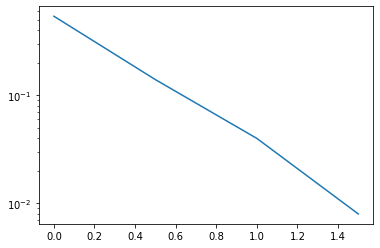

In [42]:
from matplotlib import pyplot as plt
plt.plot([0, 0.5, 1, 1.5], a)
plt.yscale('log')